**One-way ANOVA** : Compares the means of one continuous dependent variable based on three or more groups of one categorical variable.

**Two-way ANOVA** : Compares the means of one continuous dependent variable based on three or more groups of two categorical variable.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# loading in the diamond dataset from the seaborn package
diamonds = sns.load_dataset("diamonds", cache = False)

In [3]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**DATA CLEANING I**

First we will focus on one-way ANOVA. For that we will need one continuous dependent variable and at least one categorical variable.

In [4]:
# check how many diamonds are each color grade.
diamonds["color"].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [5]:
# subset the data
colorless = diamonds[diamonds["color"].isin(['E','F','H','D','I'])]
colorless = diamonds[["color","price"]].reset_index(drop=True)

Grade G and J have been excluded because there is many more of them and too few of them respectively.

In [6]:
# remove dropped catergories of diamond color.
colorless.color = colorless.color.cat.remove_categories(["G","J"])

In [7]:
colorless["color"].values

['E', 'E', 'E', 'I', NaN, ..., 'D', 'D', 'D', 'H', 'D']
Length: 53940
Categories (5, object): ['D', 'E', 'F', 'H', 'I']

In [8]:
# Now we will produce a third column which will be the logarithm of price
import math
colorless.insert(2, "log_price", [math.log(price) for price in colorless["price"]])

In [9]:
# drop missing rows
colorless.dropna(inplace = True)
colorless.reset_index(inplace = True, drop = True)

In [10]:
colorless.head()

,color,price,log_price
0,E,326,5.786897
1,E,326,5.786897
2,E,327,5.789960
3,I,334,5.811141
4,I,336,5.817111


In [11]:
# saving as diamonds.csv
colorless.to_csv("diamonds.csv",index=False, header=list(colorless.columns))

**One-way ANOVA**

In [12]:
diamonds = pd.read_csv(r"C:\Users\shirs\diamonds.csv")

In [13]:
diamonds.head()

,color,price,log_price
0,E,326,5.786897
1,E,326,5.786897
2,E,327,5.789960
3,I,334,5.811141
4,I,336,5.817111


One-way ANOVA helps us better understand the relationship between a continuous variable and a categorical variable.
We will start will some basic EDA(Exploratory Data Analysis) by creating a boxplot.

<Axes: xlabel='color', ylabel='log_price'>

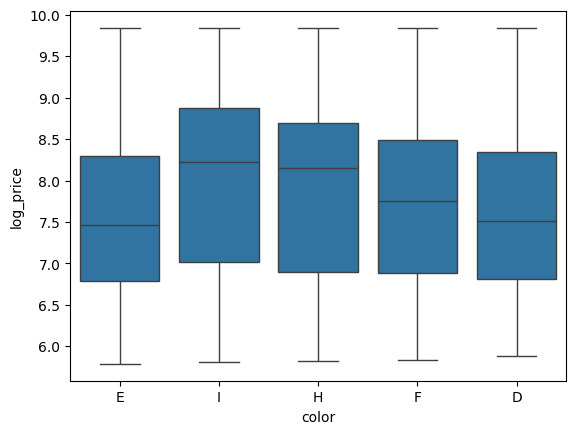

In [14]:
# create boxplot to show distribution of price by color grade
sns.boxplot(x= "color", y="log_price", data = diamonds)

We can see that there is a lot of overlap in the distribution of log price by color grade. But we cannot say if this is statistically significant.

Now, we will create a regression model in order to run ANOVA.

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [16]:
# we will create a simple linear regression model
ols_formula = "log_price ~ C(color)"

In [17]:
OLS = ols(formula = ols_formula, data = diamonds)

In [18]:
model = OLS.fit()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     265.0
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          3.61e-225
Time:                        12:03:54   Log-Likelihood:                -56182.
No. Observations:               39840   AIC:                         1.124e+05
Df Residuals:                   39835   BIC:                         1.124e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.6169      0.012    632.421      0.000       7.593       7.641
C(color)[T.E]    -0.0375      0.016     -2.394      0.017      -0.068      -0.007
C(color)[T.F]     0.1455      0.016      9.240      0.000       0.115       0.176
C(color)[T.H]     0.3015      0.016     18.579      0.000       0.270       0.333
C(color)[T.I]     0.4061      0.018     22.479      0.000       0.371       0.441
==============================================================================
Omnibus:                     7112.992   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1542.881
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       2.049   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model summary, the color grades associated beta coeffients all have p-values less than 0.05. But to know if there is a significant color difference between each color grade, we need one-way ANOVA.


State null and alternate hypothesis

**Null hypothesis**: There is no difference in the price of diamonds based on color grade.

$$H_0: price_D=price_E=price_F=price_H=price_I$$

**Alternate hypothesis**: There is difference in the price of diamonds based on color grade.

$$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$$

In [20]:
# Run one way ANOVA
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,1041.690290,260.422572,264.987395,3.609774e-225
Residual,39835.0,39148.779822,0.982773,NaN,NaN


In [21]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(color),1041.690290,4.0,264.987395,3.609774e-225
Residual,39148.779822,39835.0,NaN,NaN


In [22]:
sm.stats.anova_lm(model,typ=3)

,sum_sq,df,F,PR(>F)
Intercept,393066.804852,1.0,399956.684283,0.000000e+00
C(color),1041.690290,4.0,264.987395,3.609774e-225
Residual,39148.779822,39835.0,NaN,NaN


Since the p-value(`PR(>F)`) is very small, we can **reject** the null hypothesis that there is no difference in the price of diamonds based on color grade.

**DATA CLEANING II**

In [23]:
diamonds = sns.load_dataset("diamonds")

In [24]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


We will go through a similar process as above. But here, for two-way ANOVA, we will select two categorical variables (`color` and `cut`).

In [25]:
diamonds2 = diamonds[["color","cut","price"]]
diamonds2 = diamonds2[diamonds2["color"].isin(['D','E','F','H','I'])]
diamonds2.color = diamonds2.color.cat.remove_categories(['G','J'])
diamonds2 = diamonds2[diamonds2["cut"].isin(["Ideal","Premium","Very Good"])]
diamonds2.cut = diamonds2.cut.cat.remove_categories(["Good","Fair"])
diamonds2.dropna(inplace = True)
diamonds2.reset_index(inplace = True, drop = True)
diamonds2.insert(3,"log_price", [math.log(price) for price in diamonds2["price"]])

In [26]:
diamonds2.head()

,color,cut,price,log_price
0,E,Ideal,326,5.786897
1,E,Premium,326,5.786897
2,I,Premium,334,5.811141
3,I,Very Good,336,5.817111
4,H,Very Good,337,5.820083


In [27]:
diamonds2.to_csv('diamonds2.csv', index=False, header=list(diamonds2.columns))

**Two-way ANOVA**

In [28]:
diamonds2 = pd.read_csv(r"C:\Users\shirs\diamonds2.csv")

In [29]:
diamonds2.head()

,color,cut,price,log_price
0,E,Ideal,326,5.786897
1,E,Premium,326,5.786897
2,I,Premium,334,5.811141
3,I,Very Good,336,5.817111
4,H,Very Good,337,5.820083


We will create a multiple linear regression model with two categorical variables (`color` and `cut`) and a variable to account for the interaction term between `color` and `cut`.

In [30]:
ols_formula = "log_price ~ C(color) + C(cut) + C(color):C(cut)"

In [31]:
OLS = ols(formula = ols_formula, data = diamonds2)

In [32]:
model2 = OLS.fit()

In [33]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     119.5
Date:                Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                        12:03:56   Log-Likelihood:                -49159.
No. Observations:               34935   AIC:                         9.835e+04
Df Residuals:                   34920   BIC:                         9.847e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4567      0.019    401.583      0.000       7.420       7.493
C(color)[T.E]                        -0.0056      0.024     -0.231      0.817      -0.053       0.042
C(color)[T.F]                         0.1755      0.024      7.166      0.000       0.128       0.224
C(color)[T.H]                         0.2756      0.026     10.739      0.000       0.225       0.326
C(color)[T.I]                         0.3787      0.028     13.294      0.000       0.323       0.435
C(cut)[T.Premium]                     0.2828      0.031      9.153      0.000       0.222       0.343
C(cut)[T.Very Good]                   0.2295      0.031      7.290      0.000       0.168       0.291
C(color)[T.E]:C(cut)[T.Premium]      -0.0322      0.040     -0.800      0.424      -0.111       0.047
C(color)[T.F]:C(cut)[T.Premium]       0.0313      0.040      0.775      0.438      -0.048       0.110
C(color)[T.H]:C(cut)[T.Premium]       0.0947      0.041      2.308      0.021       0.014       0.175
C(color)[T.I]:C(cut)[T.Premium]       0.0841      0.046      1.832      0.067      -0.006       0.174
C(color)[T.E]:C(cut)[T.Very Good]    -0.0931      0.041     -2.294      0.022      -0.173      -0.014
C(color)[T.F]:C(cut)[T.Very Good]    -0.1013      0.041     -2.459      0.014      -0.182      -0.021
C(color)[T.H]:C(cut)[T.Very Good]    -0.0247      0.043     -0.576      0.564      -0.109       0.059
C(color)[T.I]:C(cut)[T.Very Good]     0.0359      0.048      0.753      0.451      -0.057       0.129
==============================================================================
Omnibus:                     4862.888   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1246.556
Skew:                           0.108   Prob(JB):                    2.06e-271
Kurtosis:                       2.100   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the summary, many of the color grades' and cuts' beta coefficients have a p-value of less than 0.05 (`P>|t|`). Some of the interactions also seem statistically significant. 
Here is where we use two-way ANOVA to further examine the relationships between price and color grade and cut.

First, we have to state the three pairs of null and alternate hypotheses.

**Null hypothesis(color)** : There is no difference in the price of diamonds based on color.
$$H_0 : price_D = price_E = price_F = price_H = price_I$$

**Alternate hypothesis(color)** : There is a difference in the price of diamonds based on color.
$$H_1 : \text{Not } price_D = price_E = price_F = price_H = price_I$$

**Null hypothesis(cut)** : There is no difference in the price of diamonds based on cut.
$$H_0 : price_{Ideal} = price_{Premium} = price_{Very \space Good}$$

**Alternate hypothesis(cut)** : There is a difference in the price of diamonds based on cut.
$$H_0 : \text{Not } price_{Ideal} = price_{Premium} = price_{Very \space Good}$$

**Null hypothesis(Interaction)** : 
$$H_0 : \text{The effect of color on diamond price is independent of the cut, and vice versa.}$$

**Alternate hypothesis(Interaction)** : 
$$H_1 : \text{There is an interaction effect between color and cut on diamond price.}$$

In [34]:
# run two-way ANOVA 
sm.stats.anova_lm(model2, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(color),4.0,977.195814,244.298954,250.021037,3.747388e-212
C(cut),2.0,630.641441,315.320721,322.706309,1.348511e-139
C(color):C(cut),8.0,27.478611,3.434826,3.515279,4.531734e-04
Residual,34920.0,34120.806577,0.977114,NaN,NaN


In [35]:
sm.stats.anova_lm(model2, typ=2)

,sum_sq,df,F,PR(>F)
C(color),926.361461,4.0,237.014783,3.481145e-201
C(cut),630.641441,2.0,322.706309,1.348511e-139
C(color):C(cut),27.478611,8.0,3.515279,4.531734e-04
Residual,34120.806577,34920.0,NaN,NaN


In [36]:
sm.stats.anova_lm(model2, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,157578.043681,1.0,161268.910012,0.000000e+00
C(color),319.145817,4.0,81.655250,4.134649e-69
C(cut),100.144107,2.0,51.244864,5.987341e-23
C(color):C(cut),27.478611,8.0,3.515279,4.531734e-04
Residual,34120.806577,34920.0,NaN,NaN


As we can see, all the p-values(column `PR(>F)`) are very small, we can reject all 3 null hypotheses.

**ANOVA post hoc test**

Performs a pairwise comparison between all available groups while controlling for the error rate. 

If we run multiple hypothesis tests, all with a confidence level of 95%, there is an increasing chance of false positive, that is falsely rejecting the null hypothesis.
This is where the necessity for post hoc test comes in, it allows us to run many hypothesis tests while remaining confident about the accuracy of the results.

We will run a post hoc test on one-way ANOVA. Specifically, **Tukey's HSD(honestly significant different)test**.

In [37]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [39]:
tukey_oneway = pairwise_tukeyhsd(endog = colorless["log_price"], groups = colorless["color"], alpha = 0.05)

In [40]:
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
D,E,-0.0375,0.1169,-0.0802,0.0052,False
D,F,0.1455,0.0,0.1026,0.1885,True
D,H,0.3015,0.0,0.2573,0.3458,True
D,I,0.4061,0.0,0.3568,0.4553,True
E,F,0.183,0.0,0.1441,0.2219,True
E,H,0.339,0.0,0.2987,0.3794,True
E,I,0.4436,0.0,0.3978,0.4893,True
F,H,0.156,0.0,0.1154,0.1966,True
F,I,0.2605,0.0,0.2145,0.3065,True
H,I,0.1045,0.0,0.0573,0.1517,True


The table above shows pairwise comparison between the prices of two diamonds color grades. The `reject` helps to determine if we can reject or fail to reject which of the null hypotheses.
Except for D and E, we can reject all of the null hypotheses. The value in the `reject` column for D and E is False. This indicates that the prices of diamonds of grade D and grade E is same.